**Desafio - Projeto Cientista Chefe**

**Candidato:** Vitor Marx Melo Silva

**Contexto**

Neste projeto, você trabalhará com uma versão levemente modificada dos dados
coletados pelo Departamento de Polícia de Seattle.

Para facilitar a administração, o Departamento de Polícia de Seattle dividiu a cidade em 5 partes, cada uma com uma delegacia. Cada parte foi subdividida em setores, que por sua vez foram divididos em beats, somando um total de 17 setores e 51 beats (mais detalhes em [link](https://www.seattle.gov/police/information-and-data/tweets-by-beat)).

Suponha que você esteja fazendo uma consultoria para a prefeitura de Seattle com o objetivo de automatizar o processo de geração de relatórios. Sua responsabilidade atual é lidar com dados que caracterizam o uso da força por parte da polícia.

## Preparando os dados para análise

**1. Importação de bibliotecas**

As bibliotecas utilizadas foram as bibliotecas comuns de manipulação de dados (numpy e pandas) e plotagem gráfica (matplotlib e seaborn). Foram importadas também as principais bibliotecas do scikit-learn para construção e avaliação de modelos de aprendizado de máquina

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import date, datetime

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import classification_report, accuracy_score, f1_score

from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

**2. Carregamento dos dados**

Os dados fornecidos pelo [Site](https://www.seattle.gov/police/information-and-data/tweets-by-beat) da polícia de Seattle podem ser baixados em formato .csv e assim manipulados pela biblioteca do pandas. A base de dados foi salva e importada a partir do Google Drive.


In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Desafio - Cientista Chefe/datasets/Use_Of_Force.csv')
raw_data.head()

,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender
0,2014UOF-0001-1377-203,251,Level 1 - Use of Force,06/07/2014 12:09:00 AM,East,CHARLIE,C2,1594,203,Black or African American,Male
1,2014UOF-0002-1098-166,218,Level 1 - Use of Force,05/30/2014 02:06:00 PM,East,GEORGE,G1,1673,166,White,Male
2,2014UOF-0003-1031-125,178,Level 1 - Use of Force,05/23/2014 05:24:00 PM,West,KING,K3,1690,125,Asian,Female
3,2014UOF-0004-767-126,179,Level 1 - Use of Force,05/26/2014 12:10:00 AM,East,EDWARD,E2,953,126,Black or African American,Male
4,2014UOF-0005-1473-172,223,Level 1 - Use of Force,06/01/2014 04:03:00 PM,South,ROBERT,R1,1145,172,Black or African American,Male


Aqui é apresentado o primeiro contato com os dados e temos as seguintes informações a respeito do que estamos trabalhando.

1.   As variável *Incident_Type* é categórica e representa o target de futuras previsões, ela identifica o nível do uso de força em uma ocorrência criminal.
2.   As variáveis *ID* e *Incident_Num* são identificadores da ocorrência criminal e não tem impacto para a variável de saída. Logo, podem se excluídos para a análise.

3.   As variáveis *Precint*, *Sector* e *Beat* são variáveis que identificam a localidade das ocorrências.

4.   *Subject_Race* indica a etnia do civil que incidiu o crim.e

5.   Por fim, *Subject_Gender* indica o gênero o qual o civil se identifica.



###**3. Limpeza de dados**

In [ ]:
# verificando se há dados faltantes ou tipagem incorreta nos dados
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14264 entries, 0 to 14263
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 14264 non-null  object
 1   Incident_Num       14264 non-null  int64 
 2   Incident_Type      14264 non-null  object
 3   Occured_date_time  14264 non-null  object
 4   Precinct           14264 non-null  object
 5   Sector             13313 non-null  object
 6   Beat               14264 non-null  object
 7   Officer_ID         14264 non-null  int64 
 8   Subject_ID         14264 non-null  int64 
 9   Subject_Race       14264 non-null  object
 10  Subject_Gender     14264 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.2+ MB


Agora que verificamos os dados, podemos tratar alguns erros vistos à priori:


1.   Dados faltantes: A variável *Sector* contém dados ausentes
2.   Tipagem incorreta: A variável *Occured_date_time* deve ser do tipo timestamp



**Trantando dados ausentes**

In [ ]:
print('PERCENTUAL DE DADOS AUSENTES POR ATRIBUTO')
print(f'{raw_data.isna().mean()}')

PERCENTUAL DE DADOS AUSENTES POR ATRIBUTO
ID                   0.000000
Incident_Num         0.000000
Incident_Type        0.000000
Occured_date_time    0.000000
Precinct             0.000000
Sector               0.066671
Beat                 0.000000
Officer_ID           0.000000
Subject_ID           0.000000
Subject_Race         0.000000
Subject_Gender       0.000000
dtype: float64


O atributo *Sector* está com alguns dados ausentes, Vamos explorar mais essa variável para tomar a decisão de substituição ou exclusão dos dados ausentes. Sabemos que, dentro de cada *Sector*, contém 3 *Beats*, assim podemos ver se essa relação está obedecendo essa regra.

In [ ]:
# visualizando as categorias de cada atributo
print(raw_data['Sector'].unique())
print(raw_data['Beat'].unique())


['CHARLIE' 'GEORGE' 'KING' 'EDWARD' 'ROBERT' 'SAM' 'LINCOLN' 'UNION'
 'DAVID' 'FRANK' 'JOHN' 'NORA' nan 'BOY' 'OCEAN' 'QUEEN' 'WILLIAM' 'MARY']
['C2' 'G1' 'K3' 'E2' 'R1' 'K1' 'G3' 'C1' 'S1' 'L1' 'U2' 'L2' 'D3' 'F2'
 'E1' 'D1' 'J3' 'C3' 'N2' 'XX' 'R3' 'F1' 'N3' 'J1' 'U3' 'L3' 'B1' 'O3'
 'S2' 'S3' 'R2' 'Q2' 'K2' 'D2' 'W3' 'N1' 'B3' 'F3' 'M3' 'M2' 'G2' 'U1'
 'B2' 'Q1' 'M1' 'E3' 'Q3' 'O1' 'J2' 'W2' 'W1' 'O2' '99' '-' '0']


Podemos obsevar as categorias '*XX*', '*99*', '*-*' e '*0*' na variável *Beat*. Possivelmente elas não tem associações com nenhum setor e estão gerando os dados faltantes. Para confirmar essa suposição, vamos calcular a quantidade de amostras para estas categorias.

In [ ]:
def count_feature_nan(data, value):
  count = 0
  for i in data:
    if i == value:
      count += 1
  return count

qtd_XX = count_feature_nan(raw_data['Beat'], 'XX')
qtd_hifen = count_feature_nan(raw_data['Beat'], '-')
qtd_99 = count_feature_nan(raw_data['Beat'], '99')
qtd_0 = count_feature_nan(raw_data['Beat'], '0')

print('Quantidade de valores ausentes da categorias XX, -, 99, 0:')
print(f'XX: {qtd_XX}\n-: {qtd_hifen}\n99: {qtd_99}\n0: {qtd_0}\n')

total = qtd_XX + qtd_hifen + qtd_99 + qtd_0
print(f'Total: {total}')
print(f'Percentual: {total/len(raw_data):.3f}')


Quantidade de valores ausentes da categorias XX, -, 99, 0:
XX: 345
-: 557
99: 36
0: 13

Total: 951
Percentual: 0.067


Assim, vemos que todos os valores ausentes da classe Sector, se devem ao fato de *XX*, *-*, *99* e *0* não estarem relacionadas a nenhum *Sector*, assim, é seguro optar pela exclusão dos dados faltantes, visto que não afetam as informações principais dos dados.

In [ ]:
raw_data = raw_data.dropna()
raw_data.shape

(13313, 11)

**Modificando tipagem da variável *Occured_date_time***

In [ ]:
date_list = []
for d in raw_data['Occured_date_time']:
  date_obj = datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p')
  date_list.append(date_obj)

raw_data['Occured_date_time'] = date_list
raw_data.sample()


,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender
9516,2019UOF-0151-1975-18093,39742,Level 2 - Use of Force,2019-01-11 10:22:00,West,MARY,M3,1878,18979,Not Specified,Female


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13313 entries, 0 to 14005
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 13313 non-null  object        
 1   Incident_Num       13313 non-null  int64         
 2   Incident_Type      13313 non-null  object        
 3   Occured_date_time  13313 non-null  datetime64[ns]
 4   Precinct           13313 non-null  object        
 5   Sector             13313 non-null  object        
 6   Beat               13313 non-null  object        
 7   Officer_ID         13313 non-null  int64         
 8   Subject_ID         13313 non-null  int64         
 9   Subject_Race       13313 non-null  object        
 10  Subject_Gender     13313 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 1.2+ MB


**Verificando existência de dados inconsistentes**

Aqui pesquisaremos por valores os quais estão incondizentes com a categoria ou outros valores

In [ ]:
raw_data.describe()

,Incident_Num,Officer_ID,Subject_ID
count,13313.000000,13313.000000,13313.000000
mean,27201.393901,1920.587246,12059.143394
std,21695.794785,1113.773392,8148.961530
min,178.000000,7.000000,4.000000
25%,8149.000000,1262.000000,4561.000000
50%,18587.000000,1743.000000,11804.000000
75%,49793.000000,2153.000000,18658.000000
max,67083.000000,5948.000000,28277.000000


Não há inconsistência nos atributos numéricos, Vamos ver se há inconsintência nos atributos categóricos:

In [ ]:
cat_list = ['Incident_Type', 'Precinct', 'Sector', 'Beat',
            'Subject_Race', 'Subject_Gender'] 

for feature in cat_list:
  print(f'Feature: {feature}\nCategories: {raw_data[feature].unique()}\n')

Feature: Incident_Type
Categories: ['Level 1 - Use of Force' 'Level 2 - Use of Force'
 'Level 3 - Use of Force' 'Level 3 - OIS']

Feature: Precinct
Categories: ['East' 'West' 'South' 'North' 'Southwest']

Feature: Sector
Categories: ['CHARLIE' 'GEORGE' 'KING' 'EDWARD' 'ROBERT' 'SAM' 'LINCOLN' 'UNION'
 'DAVID' 'FRANK' 'JOHN' 'NORA' 'BOY' 'OCEAN' 'QUEEN' 'WILLIAM' 'MARY']

Feature: Beat
Categories: ['C2' 'G1' 'K3' 'E2' 'R1' 'K1' 'G3' 'C1' 'S1' 'L1' 'U2' 'L2' 'D3' 'F2'
 'E1' 'D1' 'J3' 'C3' 'N2' 'R3' 'F1' 'N3' 'J1' 'U3' 'L3' 'B1' 'O3' 'S2'
 'S3' 'R2' 'Q2' 'K2' 'D2' 'W3' 'N1' 'B3' 'F3' 'M3' 'M2' 'G2' 'U1' 'B2'
 'Q1' 'M1' 'E3' 'Q3' 'O1' 'J2' 'W2' 'W1' 'O2']

Feature: Subject_Race
Categories: ['Black or African American' 'White' 'Asian' 'Not Specified'
 'American Indian/Alaska Native' 'Hispanic or Latino'
 'Nat Hawaiian/Oth Pac Islander' 'Two or More Races']

Feature: Subject_Gender
Categories: ['Male' 'Female' 'Unknown' '-' 'Other' 'Transgender Male'
 'Transgender Female' 'Non-binary']



In [ ]:
raw_data['Subject_Gender'].value_counts()

Male                  9911
Female                2859
Unknown                433
-                       63
Other                   21
Transgender Female      17
Non-binary               5
Transgender Male         4
Name: Subject_Gender, dtype: int64

Em *Subject_Gender*, encontramos a categoria "*-*" a qual não é algo informativo para a variável. Porém, dentre as diversas categorias, podemos ver que é possível dividí-la no aspecto Cisgênero e LGBTQIA+ de identidade de gênero. Logo, as categorias que derivam de pessoas da esfera LGBTQIA+ serão enquadradas em "Other", pois, além das várias subcategorias, estão em menor número e desbalanceiam a distribuição das amostras de gêneros.

In [ ]:
lgbtqia_cats = ['Unknown', '-', 'Transgender Female', 'Non-binary', 'Transgender Male']

for i in range(len(lgbtqia_cats)):
  raw_data.loc[raw_data['Subject_Gender'] == lgbtqia_cats[i], 'Subject_Gender'] = 'Other'

print(raw_data['Subject_Gender'].unique())
print(raw_data['Subject_Gender'].value_counts())

['Male' 'Female' 'Other']
Male      9911
Female    2859
Other      543
Name: Subject_Gender, dtype: int64


Avaliando a variável *Subject_Race*

In [ ]:
raw_data['Subject_Race'].value_counts()

White                            5451
Black or African American        4412
Not Specified                    2107
Hispanic or Latino                541
Asian                             450
American Indian/Alaska Native     198
Nat Hawaiian/Oth Pac Islander     114
Two or More Races                  40
Name: Subject_Race, dtype: int64

Tudo OK

**Excluindo atributos que não agregam informação**

In [ ]:
drop = ['ID', 'Officer_ID']
raw_data = raw_data.drop(drop, axis=1)
raw_data.head(3)

,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Subject_ID,Subject_Race,Subject_Gender
0,251,Level 1 - Use of Force,2014-06-07 00:09:00,East,CHARLIE,C2,203,Black or African American,Male
1,218,Level 1 - Use of Force,2014-05-30 14:06:00,East,GEORGE,G1,166,White,Male
2,178,Level 1 - Use of Force,2014-05-23 17:24:00,West,KING,K3,125,Asian,Female


## Análise de dados

#### 1️⃣ Com relação à distribuição dos incidentes no tempo, é possível encontrar picos ou linhas de tendência dentro dos dias, meses, semanas ou dos anos?

Para responder essa questão é necessário podemos minerar a variável relativa ao tempo em que ocorreu as incidências.

A partir do atributo *Occured_date_time* podemos obter as variáveis:

   *  Year: Ano em que ocorreu a incidência
   *  Month: Mês em que ocorreu a incidência
   *  Day: Dia da semana em que ocorreu a incidência
   *  Hour: Horário em que ocorreu a incidência

In [ ]:
# Formando o dataset de incidentes no tempo
incidents_data = raw_data[['Occured_date_time', 'Incident_Type']]
#incidents_data.head()

In [ ]:
incidents_data['Day'] = raw_data['Occured_date_time'].dt.day_name()
incidents_data['Month'] = raw_data['Occured_date_time'].dt.month_name()

incidents_data['Year'] = raw_data['Occured_date_time'].dt.year
incidents_data['Hour'] = raw_data['Occured_date_time'].dt.hour

incidents_data = incidents_data.drop(['Occured_date_time'], axis=1)
incidents_data.head()

,Incident_Type,Day,Month,Year,Hour
0,Level 1 - Use of Force,Saturday,June,2014,0
1,Level 1 - Use of Force,Friday,May,2014,14
2,Level 1 - Use of Force,Friday,May,2014,17
3,Level 1 - Use of Force,Monday,May,2014,0
4,Level 1 - Use of Force,Sunday,June,2014,16


##### **Procurando tendências para incidentes durante as horas do dia**
Para encontrar-mos uma tendência dentro das horas do dia, podemos avaliar o número de incidência dos crimes em relação aos horários que eles geralmente ocorrem.

In [ ]:
# função para calcular o número de incidências total de uma variável
def incidents_num_by_feature(value_list, feature, data):
  num_total = []
  for i in value_list:
    total = 0
    dataset = data.loc[data[feature]==i]
    total = len(dataset)
    num_total.append(total)

  return num_total

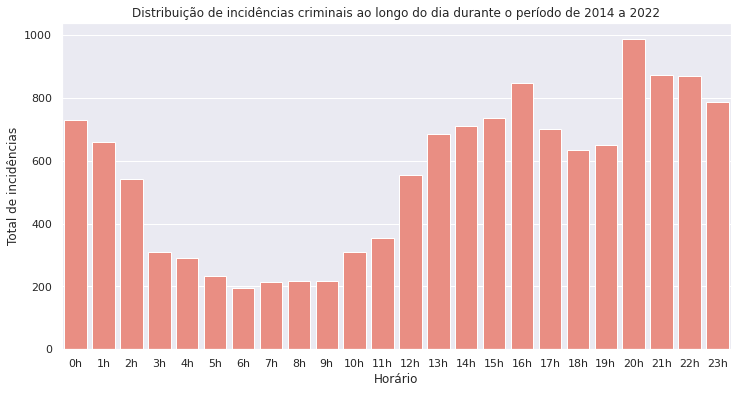

In [ ]:
hours = ['0h', '1h', '2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', '10h', '11h', '12h',
         '13h', '14h', '15h', '16h', '17h', '18h', '19h', '20h', '21h', '22h', '23h'] # apenas para xlabel do gráfico

incidents_by_hour = incidents_num_by_feature(range(0,24),'Hour',incidents_data) # calculando o total de incidências em cada hora do dia

hour = pd.DataFrame({'Hour':hours,
                     'total_of_incidents':incidents_by_hour,                     
                    })

fig, ax1 = plt.subplots(figsize=(12,6))
sns.set_theme(style='darkgrid')
sns.barplot(data=hour, x='Hour', y='total_of_incidents', color='salmon')
plt.title("Distribuição de incidências criminais ao longo do dia durante o período de 2014 a 2022")
plt.ylabel("Total de incidências")
plt.xlabel('Horário')

plt.show()

**Por meio do gráfico acima podemos observar o total de incidências de crimes em cada hora do dia durante os últimos 9 anos:**

*   **A incidência de crimes tende a cair durante a madrugada à medida em que se aproxima o turno matutino, onde tem seus menores índices (entre 6h e 9h).**

*   **As incidências aumentam conforme nos aproximamos do período noturno, onde a grande incidência de crimes aconteceu, tendo seu  pico por volta das 20h e se mantém alta neste período** 

In [ ]:
force = incidents_data.groupby(['Incident_Type', 'Hour','Year']).count()
force = force.reset_index(level=['Incident_Type', 'Hour','Year'])
force.drop(['Month'], axis=1, inplace=True)
force.rename(columns={'Day': 'Quantidade'}, inplace = True)

force_total = incidents_data.groupby(['Incident_Type', 'Hour']).count()
force_total = force_total.reset_index(level=['Incident_Type', 'Hour'])
force_total.drop(['Month', 'Year'], axis=1, inplace=True)
force_total.rename(columns={'Day': 'Quantidade'}, inplace = True) 


fig = px.bar(force, x='Hour', y='Quantidade', color='Incident_Type', animation_frame='Year', title='Quantidade de aplicação do uso de força por hora no ano')
fig.show()

fig2 = px.bar(force_total, x='Hour', y='Quantidade', color='Incident_Type', title='Quantidade de aplicação do uso de força por hora de 2014 a 2019')
fig2.show() 
#force

* O gráfico iterativo mostra o uso de força ao longo dos anos. Observa-se que no ano em que o Level 2 do uso de força foi utilizado de forma massiva, houve a diminuição do número de incidentes criminais no ano seguinte. poderemos observar isso melhor quando lidarmos com a análise anual.

* O gráfico geral, mostra que a proporção do uso de força Level 2 foi maior no turno da noite no período de 2014 a 2022.

##### **Procurando tendências para incidentes durante os dias da semana**

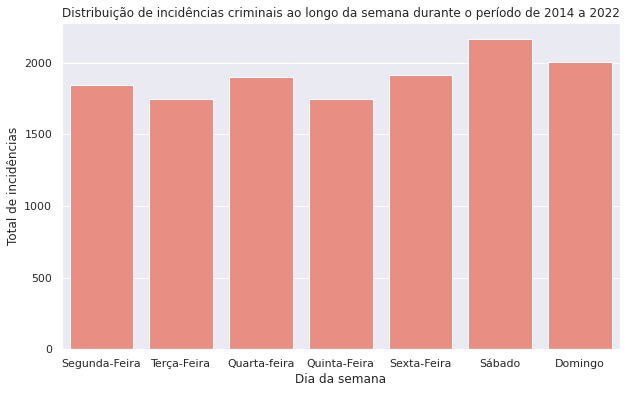

In [ ]:
days_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # dias da semana
ptbr_days_name = ['Segunda-Feira', 'Terça-Feira', 'Quarta-feira', 'Quinta-Feira', 'Sexta-Feira', 'Sábado', 'Domingo'] # apenas para xlabel do gráfico

incidents_by_day = incidents_num_by_feature(days_name,'Day', incidents_data)

day = pd.DataFrame({'Day':ptbr_days_name,
                    'total_of_incidents':incidents_by_day,
                    })

fig, ax1 = plt.subplots(figsize=(10,6))
sns.set_theme(style='darkgrid')
sns.barplot(data=day, x='Day', y='total_of_incidents', color='salmon')
plt.title("Distribuição de incidências criminais ao longo da semana durante o período de 2014 a 2022")
plt.ylabel("Total de incidências")
plt.xlabel('Dia da semana')


plt.show()

**Conforme o gráfico acima, podemos ver que ao longo dos últimos 9 anos:**
*  **As incidências de crime durante a semana são distribuídas, em média, igualitariamente, com um leve pico aos sábados**


In [ ]:
force = incidents_data.groupby(['Incident_Type', 'Day','Year']).count()
force = force.reset_index(level=['Incident_Type', 'Day','Year'])
force.drop(['Month'], axis=1, inplace=True)
force.rename(columns={'Hour': 'Quantidade'}, inplace = True)

force_total = incidents_data.groupby(['Incident_Type', 'Day']).count()
force_total = force_total.reset_index(level=['Incident_Type', 'Day'])
force_total.drop(['Month', 'Year'], axis=1, inplace=True)
force_total.rename(columns={'Hour': 'Quantidade'}, inplace = True) 


fig = px.bar(force, x='Day', y='Quantidade', color='Incident_Type', animation_frame='Year', title='Quantidade de aplicação do uso de força por dia no ano')
fig.show()

fig2 = px.bar(force_total, x='Day', y='Quantidade', color='Incident_Type', title='Quantidade de aplicação do uso de força por dia de 2014 a 2019')
fig2.show() 

##### **Procurando tendências para incidentes ao longo dos meses**

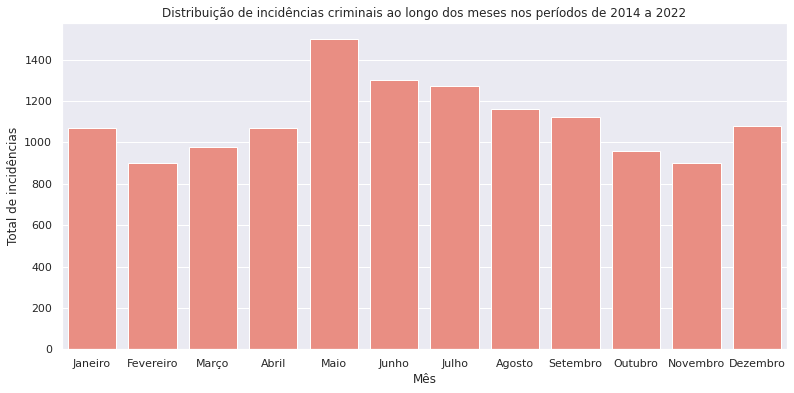

In [ ]:
month_name = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October',
              'November', 'December']

ptbr_month_name = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro',
                  'Novembro', 'Dezembro'] # apenas para o xlabel do grágico

incidents_by_month = incidents_num_by_feature(month_name,'Month', incidents_data)

month = pd.DataFrame({'Month':ptbr_month_name,
                    'total_of_incidents':incidents_by_month,
                    })

fig, ax1 = plt.subplots(figsize=(13,6))
sns.set_theme(style='darkgrid')
sns.barplot(data=month, x='Month', y='total_of_incidents', color='salmon')
plt.title("Distribuição de incidências criminais ao longo dos meses nos períodos de 2014 a 2022")
plt.ylabel("Total de incidências")
plt.xlabel('Mês')

plt.show()

**Conforme vemos no gráfico acima:**
* **Há um pico de incidências criminais no mês de Maio.**
* **A distribuição de incidentes nos meses lembra uma distribuição normal gaussiana**
* **As menores incidências de crimes ocorrem durante os meses de fevereiro e novembro**

In [ ]:
force = incidents_data.groupby(['Incident_Type', 'Month','Year']).count()
force = force.reset_index(level=['Incident_Type', 'Month','Year'])
force.drop(['Hour'], axis=1, inplace=True)
force.rename(columns={'Day': 'Quantidade'}, inplace = True)

force_total = incidents_data.groupby(['Incident_Type', 'Month']).count()
force_total = force_total.reset_index(level=['Incident_Type', 'Month'])
force_total.drop(['Hour', 'Year'], axis=1, inplace=True)
force_total.rename(columns={'Day': 'Quantidade'}, inplace = True) 


fig = px.bar(force, x='Month', y='Quantidade', color='Incident_Type', animation_frame='Year', title='Quantidade de aplicação do uso de força por mês no ano')
fig.show()

fig2 = px.bar(force_total, x='Month', y='Quantidade', color='Incident_Type', title='Quantidade de aplicação do uso de força por mês de 2014 a 2019')
fig2.show() 

##### **Procurando tendências para incidentes ao longo dos anos**

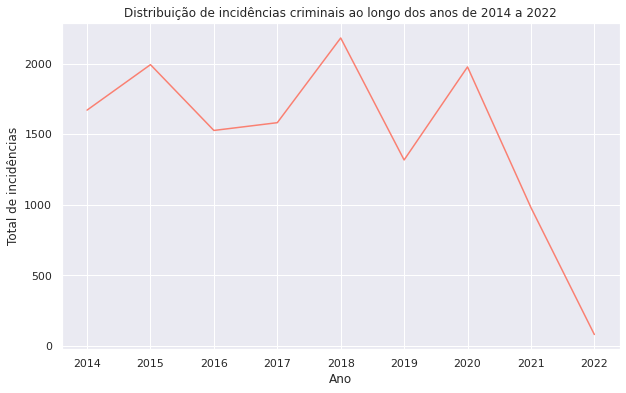

In [ ]:
years_list = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

incidents_by_year = incidents_num_by_feature(years_list,'Year',incidents_data)

year = pd.DataFrame({'Year':years_list,
                     'total_of_incidents':incidents_by_year,
                     })

fig, ax1 = plt.subplots(figsize=(10,6))
sns.set_theme(style='darkgrid')
sns.lineplot(data=year, x='Year', y='total_of_incidents', color='salmon')
plt.title("Distribuição de incidências criminais ao longo dos anos de 2014 a 2022")
plt.ylabel("Total de incidências")
plt.xlabel('Ano')


plt.show()

**O gráfico mostra que a incidência criminal tem períodos de alta e baixa ao longo dos anos**

* **A maior incidência criminal dos últimos 9 anos aconteceu em 2018**

* **Do ano de 2020 até o ano atual, a incidência de crimes tem diminuído consideravelmente, porém o número de amostras para o ano atual ainda não foi consolidada, e este índice ainda pode mudar**

In [ ]:
force_total = incidents_data.groupby(['Incident_Type', 'Year']).count()
force_total = force_total.reset_index(level=['Incident_Type', 'Year'])
force_total.drop(['Month', 'Hour'], axis=1, inplace=True)
force_total.rename(columns={'Day': 'Quantidade'}, inplace = True) 

fig = px.bar(force_total, x='Year', y='Quantidade', color='Incident_Type', title='Quantidade de aplicação do uso de força por ano (2014 a 2019)')
fig.show() 

Quando o uso de força foi massivamente Level 2, os incidentes do ano seguinte diminuíram consideravelmente

Por fim, podemos resumir as análises para a questão 1, da seguinte forma:

* As incidências de crimes ao longo desses 9 anos em Seattle, ocorreram em sua maioria no período noturno, com pico às 20H, geralmente a maior incidência é aos sábados. Porém, após o ano de 2020, quando o uso de força Level 2 foi aplicado de forma mais incisiva, a incidência de crimes diminuiu consideravelmente.


####  2️⃣ Uma métrica interessante para a polícia é o grau de reincidência por parte dos civis. Apresente o percentual de casos reincidentes em relação ao total de incidentes em cada setor e verifique se há correlação entre esta métrica e o percentual de incidentes “Level 2” calculado na questão. Que interpretação pode ser dada a este resultado?

Para responder essa questão é necessário utilizar a engenharia de dados para formar novos atributos que nos dêem informações mais específicas do que queremos encontrar.

A partir das variáveis *Subject_ID*, *Sector* e *Incident_Type* podemos obter:

* Os *Sector* associados a cada reincidente
* Total de incidentes em cada *Sector*
* A quantidade de pessoas com reincidentes criminais em cada *Sector*
* O percentual de reincidentes em cada Sector
* A quantidade de uso de força Level 2 em cada *Sector*
* Percentual de incidentes Level 2 por Sector

Utilizando algumas métricas auxiliares e análises dos resultados podemos dizer se o percentual de casos reincidentes em relação ao total de incidentes em cada setor tem correlação com o percentual de incidentes “Level 2”

In [ ]:
# criando base de dados com atributos chave
reincidents_data = raw_data.drop(['Incident_Num', 'Occured_date_time', 'Precinct',
                                  'Beat',	'Subject_Race',	'Subject_Gender'], axis=1)

reincidents_data.head()

,Incident_Type,Sector,Subject_ID
0,Level 1 - Use of Force,CHARLIE,203
1,Level 1 - Use of Force,GEORGE,166
2,Level 1 - Use of Force,KING,125
3,Level 1 - Use of Force,EDWARD,126
4,Level 1 - Use of Force,ROBERT,172


In [ ]:
# adiquirindo a lista de todos os civis reincidentes
def check_repeated_IDs(lista):
  reincidents = []
  for i in range(len(lista)):
    if lista.index(lista[i])!=i:
      if lista[i] not in reincidents:
        reincidents.append(lista[i])
  return reincidents

subjects_list = reincidents_data['Subject_ID'].tolist()
reincidents_list = check_repeated_IDs(subjects_list)

In [ ]:
# refinando a busca para encontrarmos o número de reincidência destes civis
num_reincidents_list = []
for re in reincidents_list:
  counter = 0
  for i in reincidents_data['Subject_ID']:
    if i == re:
      counter += 1
  num_reincidents_list.append(counter)

reinc_data = pd.DataFrame({'Subject_ID':reincidents_list,
                           'num_of_reincidents':num_reincidents_list,
                          })

In [ ]:
# formando base de dados dos reincidentes
reinc_data = pd.merge(reinc_data, reincidents_data, on=['Subject_ID'])
reinc_data = reinc_data.drop_duplicates(subset='Subject_ID', keep='first')

In [ ]:
# Calculando o total de reincidências em cada Sector
reinc_data1 = reinc_data.drop(['Subject_ID'], axis=1)
reinc_data_per_sector = reinc_data1.groupby(['Sector']).sum()
reinc_data_per_sector = reinc_data_per_sector.reset_index()
reinc_data_per_sector.head(17)

,Sector,num_of_reincidents
0,BOY,373
1,CHARLIE,261
2,DAVID,817
3,EDWARD,1088
4,FRANK,323
5,GEORGE,530
6,JOHN,310
7,KING,1093
8,LINCOLN,443
9,MARY,666


In [ ]:
# calculando o número total de incidências em cada Sector
sectors_list = ['GEORGE', 'KING', 'LINCOLN', 'DAVID', 'FRANK', 'JOHN', 'NORA',
           'BOY', 'MARY', 'SAM', 'EDWARD', 'CHARLIE', 'QUEEN', 'UNION',
           'ROBERT', 'OCEAN', 'WILLIAM']

incidents_by_sector = incidents_num_by_feature(sectors_list, 'Sector',raw_data)

sector = pd.DataFrame({'Sector':sectors_list,
                     'num_of_incidents':incidents_by_sector,
                     })

sector.head(17)

,Sector,num_of_incidents
0,GEORGE,688
1,KING,1505
2,LINCOLN,644
3,DAVID,1049
4,FRANK,471
5,JOHN,441
6,NORA,913
7,BOY,525
8,MARY,998
9,SAM,947


In [ ]:
# combinando os dados encontrados
data_sector_info = pd.merge(reinc_data_per_sector, sector, on=['Sector'])

# calculando o percentual de casos reincidentes em relação ao total de incidentes em cada setor
data_sector_info['percent_of_reincidents'] = data_sector_info['num_of_reincidents'] / data_sector_info['num_of_incidents'] 
data_sector_info.head(17)

,Sector,num_of_reincidents,num_of_incidents,percent_of_reincidents
0,BOY,373,525,0.710476
1,CHARLIE,261,425,0.614118
2,DAVID,817,1049,0.778837
3,EDWARD,1088,1738,0.626007
4,FRANK,323,471,0.685775
5,GEORGE,530,688,0.770349
6,JOHN,310,441,0.702948
7,KING,1093,1505,0.726246
8,LINCOLN,443,644,0.687888
9,MARY,666,998,0.667335


In [ ]:
# Calculando o total de incidentes por uso de força em cada setor
level_total = []

def total_incidents_by_Level_and_Sector(level):
  dataset = raw_data.loc[raw_data['Incident_Type']==level]

  sec_name = dataset['Sector'].value_counts().index.tolist()
  total = list(dataset['Sector'].value_counts())

  return sec_name, total

sec_name1, total1 = total_incidents_by_Level_and_Sector('Level 1 - Use of Force') 
sec_name2, total2 = total_incidents_by_Level_and_Sector('Level 2 - Use of Force') 
sec_name3, total3 = total_incidents_by_Level_and_Sector('Level 3 - Use of Force') 
sec_nameosi, totalosi = total_incidents_by_Level_and_Sector('Level 3 - OIS')
 
# incluindo d 0 nos Sectors que não se utilizou nível 2 de força
totalosi.append(0)
totalosi.append(0)

level_of_force = pd.DataFrame({'Sector':sec_name2,
                               'Level1_of_force_applyed':total1,
                               'Level2_of_force_applyed':total2,
                               'Level3_of_force_applyed':total3,
                               'Level3OSI_of_force_applyed':totalosi,
                               })

level_of_force['total_of_force_applyed'] = level_of_force.sum(axis=1) # total de nível de força no Sector

level_of_force['perc_of_force2_applyed'] = level_of_force['Level2_of_force_applyed']/level_of_force['total_of_force_applyed'] # porcentual de força Level 2 utilizada no Sector


level_of_force = level_of_force.drop(['Level1_of_force_applyed','Level2_of_force_applyed','Level3_of_force_applyed','Level3OSI_of_force_applyed','total_of_force_applyed'], axis=1)

data_quest2 = pd.merge(data_sector_info, level_of_force, on=['Sector']) # dataset contendo as informações específicas necessárias para análise
data_quest2.head(17)


,Sector,num_of_reincidents,num_of_incidents,percent_of_reincidents,perc_of_force2_applyed
0,BOY,373,525,0.710476,0.219403
1,CHARLIE,261,425,0.614118,0.215164
2,DAVID,817,1049,0.778837,0.291010
3,EDWARD,1088,1738,0.626007,0.433792
4,FRANK,323,471,0.685775,0.205128
5,GEORGE,530,688,0.770349,0.207237
6,JOHN,310,441,0.702948,0.161804
7,KING,1093,1505,0.726246,0.330709
8,LINCOLN,443,644,0.687888,0.239544
9,MARY,666,998,0.667335,0.356198


In [ ]:
# adiquirindo informação de correlação entre as variáveis
corr_matrix = data_quest2.corr()
corr_matrix['perc_of_force2_applyed'].sort_values(ascending=False)

perc_of_force2_applyed    1.000000
num_of_incidents          0.869178
num_of_reincidents        0.840564
percent_of_reincidents   -0.010646
Name: perc_of_force2_applyed, dtype: float64

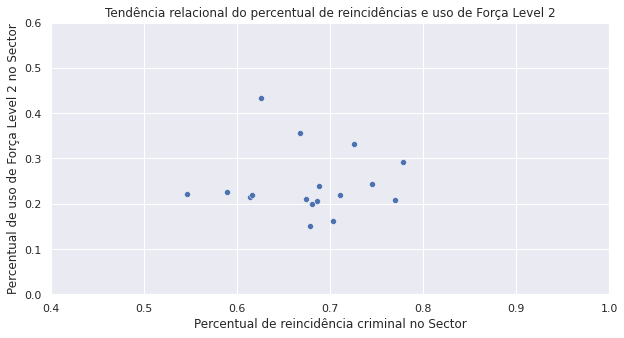

In [ ]:
from matplotlib import axis
# mostrando os resultados graficamente
fig = plt.figure(figsize=(10,5))
sns.scatterplot(data=data_quest2, x='percent_of_reincidents', y='perc_of_force2_applyed')
plt.title('Tendência relacional do percentual de reincidências e uso de Força Level 2')
plt.xlabel('Percentual de reincidência criminal no Sector')
plt.ylabel('Percentual de uso de Força Level 2 no Sector')
plt.xlim(.4,1)
plt.ylim(0,.6)
plt.show()

**A correlação indica uma relação linear entre uma variável e outra, neste caso, não há correlação entre o percentual de reincidentes com relação a incidentes no *Sector* e o percentual do uso de força Level 2. Conforme o gráfico mostra, não há uma relação linear forte positiva nem negativa das variáveis.**

## Aprendizado de Máquina

3️⃣ Considerando que é interessante para a Polícia de Seattle predizer o possível nível do uso da forca policial empregado em uma ocorrência, crie um modelo de classificação utilizando técnicas clássicas de Aprendizagem de Máquina (por exemplo: Regressão logística, Árvores de Decisão, Máquina de Vetores de Suporte (SVM)). Utilize diferentes métricas para avaliar o seu modelo. Qual acurácia seu modelo obteve e a que se deve isto?



In [ ]:
# verificando os atributos restantes após todas as manipulações
raw_data.columns

Index(['Incident_Num', 'Incident_Type', 'Occured_date_time', 'Precinct',
       'Sector', 'Beat', 'Subject_ID', 'Subject_Race', 'Subject_Gender'],
      dtype='object')

Na análise de dados vimos que, ao longo dos anos, é perceptível o aumento de incidentes criminais em determinados horários, meses e dias da semana. Claro que essa informação é generalizada e cada Sector pode ter os seus dias, horários e meses específicos com sua própria demanda. Contudo, *Ano*, *Dia da Semana* e *Mês* são atributos informativos e que podem ajudar nas previsões.


In [ ]:
# adicionando as variáveis horário, mês e dia da semana ao dataset
raw_data['Month'] = raw_data['Occured_date_time'].dt.month_name()
raw_data['Hour'] = raw_data['Occured_date_time'].dt.hour
raw_data['Day'] = raw_data['Occured_date_time'].dt.day_name()

In [ ]:
y = raw_data['Incident_Type'] # target

# transformando categórico em int no target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# excluindo variáveis não utilizáveis
X = raw_data.drop(['Incident_Num', 'Incident_Type', 'Occured_date_time', 'Subject_ID'], axis=1) # excluindo variáveis de identificação

print(X.shape, y_encoded.shape)

(13313, 8) (13313,)


In [ ]:
# separando dados de treino, validação e teste
# Treino e Validação = 80%
# Teste = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# vendo o tipo de cada atributo
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10650 entries, 11446 to 4392
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Precinct        10650 non-null  object
 1   Sector          10650 non-null  object
 2   Beat            10650 non-null  object
 3   Subject_Race    10650 non-null  object
 4   Subject_Gender  10650 non-null  object
 5   Month           10650 non-null  object
 6   Hour            10650 non-null  int64 
 7   Day             10650 non-null  object
dtypes: int64(1), object(7)
memory usage: 748.8+ KB


In [ ]:
num_features = ['Hour'] # variáveis numéticas
cat_features = ['Precinct', 'Sector', 'Beat', 'Subject_Race', 'Subject_Gender',  'Day', 'Month'] # variáveis categóricas

# utilizando pipeline para pre-processamento
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('normalization', StandardScaler())
                         ])

full_pipeline = ColumnTransformer([
                          ('num_data', num_pipeline, num_features),
                          ('cat_data', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_prepared = full_pipeline.fit_transform(X_train)
X_prepared.toarray()

array([[0.35345526, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.04349385, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.90548613, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.35345526, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.18150157, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76747841, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

**Validando os modelos**

In [ ]:
# definindo modelos para avaliação
models = [RandomForestClassifier(), SVC(), LogisticRegression(),
          KNeighborsClassifier(), DecisionTreeClassifier()]

# definindo métricas para tabela de resultados
MLA_columns = ['Modelo', 'Acc. treinamento', 'Acc. Teste', 'Tempo']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# definindo hiperparâmetro de validação
kfold = KFold(n_splits=10, shuffle=True)

index = 0
for i in range(len(models)):
  
  clf = models[i]

  MLA_compare.loc[index, 'Modelo'] = clf

  scores = cross_validate(clf, X_prepared, y_train, cv=kfold, return_train_score=True)


  MLA_compare.loc[index, 'Tempo'] = scores['fit_time'].mean()
  MLA_compare.loc[index, 'Acc. treinamento'] = scores['train_score'].mean()
  MLA_compare.loc[index, 'Acc. Teste'] = scores['test_score'].mean()   

  index+=1
 

MLA_compare.sort_values(by = ['Acc. Teste'], ascending = False, inplace = True)
MLA_compare


,Modelo,Acc. treinamento,Acc. Teste,Tempo
0,RandomForestClassifier(),0.968211,0.846761,5.895996
4,DecisionTreeClassifier(),0.968367,0.793239,0.208684
1,SVC(),0.789098,0.769765,5.616934
3,KNeighborsClassifier(),0.84265,0.761315,0.010742
2,LogisticRegression(),0.740344,0.738873,0.535363


**Testando o melhor modelo validado**

                        precision    recall  f1-score   support

Level 1 - Use of Force       0.88      0.92      0.90      1894
Level 2 - Use of Force       0.77      0.68      0.72       724
         Level 3 - OIS       0.62      0.59      0.60        22
Level 3 - Use of Force       0.42      0.35      0.38        23

              accuracy                           0.85      2663
             macro avg       0.67      0.63      0.65      2663
          weighted avg       0.84      0.85      0.84      2663



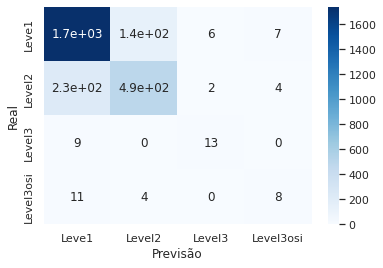

In [ ]:
# realizando pre-processamento nos dados de teste
X_test_prepared = full_pipeline.fit_transform(X_test)
X_test_prepared.toarray()

classifier = RandomForestClassifier(class_weight='balanced') # atribuindo modelo de maior acurácia no treinamento
classifier.fit(X_prepared, y_train) # treinando o modelo
y_pred = classifier.predict(X_test_prepared) # testando o modelo


# resultados
print(classification_report(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.xaxis.set_ticklabels(['Leve1', 'Level2', 'Level3', 'Level3osi'])
ax.yaxis.set_ticklabels(['Leve1', 'Level2', 'Level3', 'Level3osi']);
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

**A acurácia de 85% é alta para a natureza dos dados, porém, devido este mesmo fator, os resultados tornam-se tendenciosos uma vez que a quantidade de amostras para os usos de força nos níveis 1 e 2 são bem superiores às demais. Logo, o sistema tende a acertar muito para ocorrências nos níveis 1 e 2 mas não generaliza bem os outros níveis.**

**Apesar disso, o modelo se mostrou eficaz para diferenciar entre o uso de força Level 3 e Level 3 osi.**

**O modelo tem dificuldade em diferenciar o uso de força dos Levels 1 e 2**

**Talvez a adição de alguns outros atributos que ajudem na decisão ou a utilização de modelos de aprendizagem mais robustos, possam melhorar os resultados.**

4️⃣ Suponha que o modelo elaborado para o item 3 não possuiu acurácia razoável para os propósitos da consultoria. Visando aumentá-la, utilize uma ou mais das seguintes técnicas de Aprendizado de Máquina em uma nova versão do modelo:
* Aprendizagem Profunda     
* Aumento Artificial de Dados (Data Augmentation)
* Técnicas de Balanceamento de Dados (ex. SMOTE, under-sampling)

Foi possível melhorar a acurácia do modelo? A que se deve esse fato?

##### **Utilizando técnica de balanceamento de dados: SMOTE**

In [ ]:
# aplicado a técnica de sobreamostragem smote
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_prepared, y_train)

# mostrando nova distribuição dos dados balanceados
counter = Counter(y_train_over)
for k,v in counter.items():
	per = v / len(y_train_over) * 100
	print(f'Class= {k}\t amostras={v}\t perc: {per:.2f} %')


Class= Level 2 - Use of Force	 amostras=7540	 perc: 25.00 %
Class= Level 1 - Use of Force	 amostras=7540	 perc: 25.00 %
Class= Level 3 - OIS	 amostras=7540	 perc: 25.00 %
Class= Level 3 - Use of Force	 amostras=7540	 perc: 25.00 %


In [ ]:
# definindo métricas para tabela de resultados
MLA_columns = ['Modelo', 'Acc. treinamento', 'Acc. Teste', 'Tempo']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# definindo hiperparâmetro de validação
kfold = KFold(n_splits=10, shuffle=True)

index = 0
for i in range(len(models)):
  
  clf = models[i]

  MLA_compare.loc[index, 'Modelo'] = clf

  scores = cross_validate(clf, X_train_over, y_train_over, cv=kfold, return_train_score=True)


  MLA_compare.loc[index, 'Tempo'] = scores['fit_time'].mean()
  MLA_compare.loc[index, 'Acc. treinamento'] = scores['train_score'].mean()
  MLA_compare.loc[index, 'Acc. Teste'] = scores['test_score'].mean()   

  index+=1  

MLA_compare.sort_values(by = ['Acc. Teste'], ascending = False, inplace = True)
MLA_compare


,Modelo,Acc. treinamento,Acc. Teste,Tempo
0,RandomForestClassifier(),0.98838,0.947646,19.897545
4,DecisionTreeClassifier(),0.988384,0.921651,0.874263
1,SVC(),0.935691,0.914191,19.804873
3,KNeighborsClassifier(),0.921883,0.885975,0.037918
2,LogisticRegression(),0.68123,0.676359,1.531736


                        precision    recall  f1-score   support

Level 1 - Use of Force       0.87      0.91      0.89      1894
Level 2 - Use of Force       0.75      0.67      0.71       724
         Level 3 - OIS       0.56      0.41      0.47        22
Level 3 - Use of Force       0.40      0.35      0.37        23

              accuracy                           0.84      2663
             macro avg       0.65      0.58      0.61      2663
          weighted avg       0.83      0.84      0.83      2663



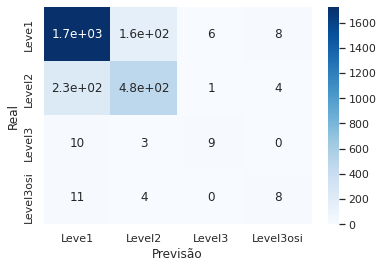

In [ ]:
classifier = RandomForestClassifier(class_weight='balanced') # atribuindo modelo de maior acurácia no treinamento
classifier.fit(X_train_over, y_train_over) # treinando o modelo
y_pred = classifier.predict(X_test_prepared) # testando o modelo


# resultados
print(classification_report(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.xaxis.set_ticklabels(['Leve1', 'Level2', 'Level3', 'Level3osi'])
ax.yaxis.set_ticklabels(['Leve1', 'Level2', 'Level3', 'Level3osi']);
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

**A aplicação da técnica de balanceamento dos dados não melhora a acurácia do modelo, há variações na precisão, f1 score e recall nas classificações.**

**Essas variações na precisão nas previsões de cada classe se devem ao balanceamento dos dados, contudo, fica nítido, após o balanceamento, que o desbalanceamento não é o problema. É provável que o modelo melhore se encontrarmos uma variável intermediadora para Level 1 e 2 do uso de força, onde há mais conflitos para a classificação**